In [11]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [12]:
# ---- Global constants ----
MAX_GAP = 3600  # seconds (1 hour)
MIN_GAP = 60    # seconds (1 minute)


In [13]:
df = pd.read_csv("../vessel-total-clean-final.csv")

# Convertir la colonne date en datetime
df['base_date_time'] = pd.to_datetime(df['base_date_time'])

# Trier par mmsi + date (si plusieurs navires)
df = df.sort_values(['mmsi', 'base_date_time'])

In [14]:
df = df.sort_values(['mmsi', 'base_date_time'])
df['delta'] = df.groupby('mmsi')['base_date_time'].diff().dt.total_seconds()

# Choisis ici le MMSI à visualiser
mmsi_example = df['mmsi'].unique()[5]
df_boat = df[df['mmsi'] == mmsi_example].copy()

gaps = df_boat[df_boat['delta'] > 100]


In [15]:
# ── Diagnostic des gaps réels ──
print(f"=== Diagnostic pour le navire {mmsi_example} ===")
for i in range(1, len(df_boat)):
    t0 = df_boat.iloc[i-1]['base_date_time']
    t1 = df_boat.iloc[i  ]['base_date_time']
    gap = (t1 - t0).total_seconds()
    if gap > MAX_GAP:
        print(f"Gap de {gap:.0f}s entre lignes {i-1} et {i} : {t0} → {t1}")
print("=== Fin du diagnostic ===\n")

=== Diagnostic pour le navire 241452000 ===
Gap de 15870s entre lignes 8 et 9 : 2023-05-25 12:07:03 → 2023-05-25 16:31:33
Gap de 4920s entre lignes 9 et 10 : 2023-05-25 16:31:33 → 2023-05-25 17:53:33
Gap de 86639s entre lignes 71 et 72 : 2023-05-25 23:57:51 → 2023-05-27 00:01:50
Gap de 86490s entre lignes 639 et 640 : 2023-05-27 23:58:34 → 2023-05-29 00:00:04
Gap de 24023s entre lignes 1022 et 1023 : 2023-05-29 12:44:22 → 2023-05-29 19:24:45
Gap de 86688s entre lignes 1184 et 1185 : 2023-05-29 23:55:16 → 2023-05-31 00:00:04
=== Fin du diagnostic ===



In [16]:
import numpy as np
import pandas as pd

def predict_gap(segment_df: pd.DataFrame,
                step: int = 60) -> pd.DataFrame:
    """Linear interpolation between two rows separated by a gap.

    Parameters
    ----------
    segment_df : DataFrame
        Exactly 2 lignes : début et fin du gap.
    step : int
        Pas de temps en secondes entre deux points interpolés.

    Returns
    -------
    DataFrame
        DataFrame contenant *tous* les points (début, intermédiaires, fin).
    """
    if len(segment_df) != 2:
        raise ValueError("segment_df doit contenir exactement 2 lignes (début et fin du gap).")

    start, end = segment_df.iloc[0], segment_df.iloc[1]
    total_sec = (end['base_date_time'] - start['base_date_time']).total_seconds()

    if total_sec <= step:
        # gap trop petit → on renvoie tel quel
        return segment_df

    # nombre de pas entiers
    n_steps = int(total_sec // step)

    # listes des timestamps
    times = [start['base_date_time'] + pd.Timedelta(seconds=i*step)
             for i in range(n_steps + 1)]

    # interpolation linéaire lat/lon
    lats = np.linspace(start['lat'], end['lat'], n_steps + 1)
    lons = np.linspace(start['lon'], end['lon'], n_steps + 1)

    # autres colonnes (on propage la même valeur)
    mmsi_val = start['mmsi']

    df_interp = pd.DataFrame({
        'mmsi': mmsi_val,
        'base_date_time': times,
        'lat': lats,
        'lon': lons
    })
    return df_interp

In [17]:

def fill_gaps_for_boat(df_boat: pd.DataFrame,
                       model,
                       step: int = 60,
                       min_gap: int = MIN_GAP,
                       max_gap: int = MAX_GAP) -> pd.DataFrame:
    """Return df with gaps between min_gap and max_gap filled at given step."""
    df_boat = df_boat.sort_values('base_date_time').copy()
    df_boat['delta'] = df_boat['base_date_time'].diff().dt.total_seconds().fillna(0)

    rows = [df_boat.iloc[[0]]]
    for i in range(1, len(df_boat)):
        gap = df_boat.iloc[i]['delta']
        if (gap <= min_gap) or (gap > max_gap):
            rows.append(df_boat.iloc[[i]])
            continue
        seg = df_boat.iloc[[i-1, i]]
        preds = predict_gap(seg, step=step)
        rows.append(preds.iloc[1:])
        rows.append(df_boat.iloc[[i]])
    return pd.concat(rows, ignore_index=True)


In [18]:
import joblib
model = joblib.load("trajectoire.pkl")


step = 60  # 1 min
min_gap_fill = MIN_GAP
max_gap_fill = MAX_GAP  # 1 hour


all_filled = []
for i in range(1, len(df_boat)):
    gap = df_boat.iloc[i]['delta']
    if (gap <= min_gap_fill) or (gap > max_gap_fill):
        continue

    row_prev = df_boat.iloc[i-1]
    row_next = df_boat.iloc[i]
    segment  = pd.DataFrame([row_prev, row_next])

    df_seg = predict_gap(segment, step=step)
    all_filled.append(df_seg)

filled_df = pd.concat(all_filled, ignore_index=True)
print("✅ Points prédits pour comblement :", len(filled_df))

✅ Points prédits pour comblement : 4740


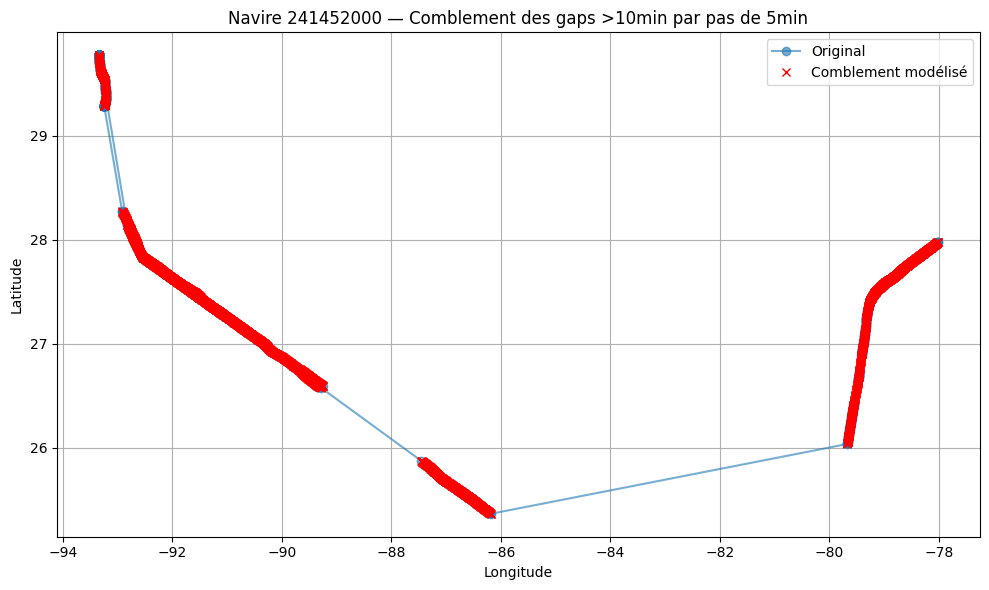

In [19]:
plt.figure(figsize=(10,6))
# trajectoire mesurée
plt.plot(df_boat['lon'], df_boat['lat'], 'o-', label='Original', alpha=0.6)
# prédictions comblées
plt.plot(filled_df['lon'], filled_df['lat'], 'x', label='Comblement modélisé', color='red')

plt.title(f"Navire {mmsi_example} — Comblement des gaps >10min par pas de 5min")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# %%  — Carte Folium
import folium

# centre grossier : milieu de la trajectoire
center = [
    0.5 * (df_boat.lat.min() + df_boat.lat.max()),
    0.5 * (df_boat.lon.min() + df_boat.lon.max())
]

m = folium.Map(location=center, zoom_start=7, tiles="cartodbpositron")

# ---------- points originaux (bleu) ----------
orig_layer = folium.FeatureGroup(name="Positions originales").add_to(m)
for lat, lon, t in zip(df_boat.lat, df_boat.lon, df_boat.base_date_time):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="#1f77b4",              # contour bleu
        fill=True, fill_color="#1f77b4", fill_opacity=0.8,
        tooltip=str(t)
    ).add_to(orig_layer)

# ---------- points comblés (rouge) ----------
if not filled_df.empty:
    fill_layer = folium.FeatureGroup(name="Positions comblées").add_to(m)
    for lat, lon, t in zip(filled_df.lat, filled_df.lon, filled_df.base_date_time):
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            color="#d62728",
            fill=True, fill_color="#d62728", fill_opacity=0.9,
            tooltip=f"Comblé : {t}"
        ).add_to(fill_layer)

# bascule d’affichage
folium.LayerControl().add_to(m)

m    # affiche la carte interactive dans le notebook